**Brian Blaylock**  
**March 27, 2018**

# Explore Contingency Table and Fractions Skill Score
## Single Day

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio,\
                                                 base_rate
from BB_HRRR.HRRR_paths import get_domains
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 3]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

In [2]:
DATES = [datetime(2018, 5, 16, 2), datetime(2018, 7, 5, 21), datetime(2018, 7, 17, 6)]
DOMAINS = ['Texas', 'Colorado', 'Utah']
NAMES = ['Mallard Fire', 'Lake Christine Fire', 'Utah Thunderstorm']

## Specify the valid Datetime of interest
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23)  # Lake Christine 1
#DATE = datetime(2018, 7, 6, 0)    # Lake Christine 2
#DATE = datetime(2018, 7, 17, 6)  # July Storm
#DATE = datetime(2018, 7, 27, 0)  # Missing GLM data
#DATE = datetime(2018, 7, 6, 0) # Test July 1, 2019

# Single Datetime: Hit Rate/ False Alarm Ratio

In [3]:
def get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
    FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line

def get_GLM_HRRR_FSS_day(DATE, DOMAIN, radius, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
    FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line


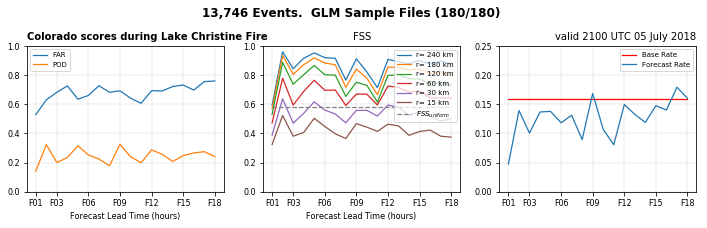

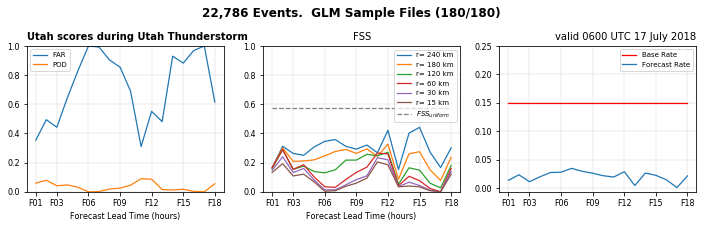

In [14]:
radii = [80, 60, 40, 20, 10, 5] # For FSS scores files available


for DATE, DOMAIN, NAME in zip(DATES[1:], DOMAINS[1:], NAMES[1:]):
    line = get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=False)

    fix, (ax1, ax2, ax3) = plt.subplots(1,3)

    events = int(line['GLM_Event_COUNT'])
    files = line['NUM_FILES']
    expected = line['EXPECTED_FILES']
    plt.suptitle('{:,} Events.  GLM Sample Files ({:}/{:})'.format(events, files, expected))
    
    plt.sca(ax1)
    A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
    B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
    C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
    D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])

    hitRate = hit_rate(A, B, C, D)
    falseAlarmRatio = false_alarm_ratio(A, B, C, D)
    baseRate = base_rate(A, B, C, D)
    FSS_uniform = 0.5 + baseRate/2

    plt.plot(range(1,19), falseAlarmRatio, label='FAR')
    plt.plot(range(1,19), hitRate, label='POD')
    plt.xlabel('Forecast Lead Time (hours)')
    #plt.ylabel('HR and FAR')
    plt.ylim([0,1])
    plt.xticks([1,3,6,9,12,15,18], ['F%02d' % f for f in [1,3,6,9,12,15,18]])
    plt.title('%s scores during %s' % (DOMAIN, NAME), loc='left', fontweight='semibold')   
    plt.grid()
    plt.legend(loc=2)
    
    plt.sca(ax2)
    FSS = [get_GLM_HRRR_FSS_day(DATE, DOMAIN, r, verbose=False) for r in radii]
    for fss, r in zip(FSS, radii):
        values = [fss['F%02d_FSS' % h] for h in range(1,19)]
        plt.plot(range(1,19), values, label='r= %s km' % (r*3))
    plt.title('FSS')
    plt.plot(range(1,19), FSS_uniform, color='grey', linestyle='--', label="$FSS_{uniform}$")
    plt.xticks(range(1,19))
    plt.legend(loc=1)
    plt.grid()
    plt.xlabel('Forecast Lead Time (hours)')
    plt.ylim([0,1])
    plt.xticks([1,3,6,9,12,15,18], ['F%02d' % f for f in [1,3,6,9,12,15,18]])
    
    plt.sca(ax3)
    # Total number of points in domain
    n = A+B+C+D
    # Total GLM points
    GLM_points = A+C
    # Total FXX points
    FXX_points = A+B
    
    plt.plot(range(1,19), GLM_points/n, label='Base Rate', color='r')
    plt.plot(range(1,19), FXX_points/n, label='Forecast Rate')
    plt.yticks(np.arange(0,.26, .05))
    plt.xticks([1,3,6,9,12,15,18], ['F%02d' % f for f in [1,3,6,9,12,15,18]])
    plt.legend(loc=1)
    plt.grid()
    plt.title('valid %s' % DATE.strftime('%H%M UTC %d %B %Y'), loc='right')
    
    plt.subplots_adjust(top=.8, wspace=.2)
    plt.savefig('./figs/fig-xx-%s_%s' % (DATE.strftime('%Y-%m-%d_%H%M'), DOMAIN))

array([336, 570, 271, 485, 669, 680, 846, 721, 636, 530, 474, 701, 110,
       643, 547, 355,  20, 523])

# Percentage of Area with Forecasted LTNG and Observed GLM Events 

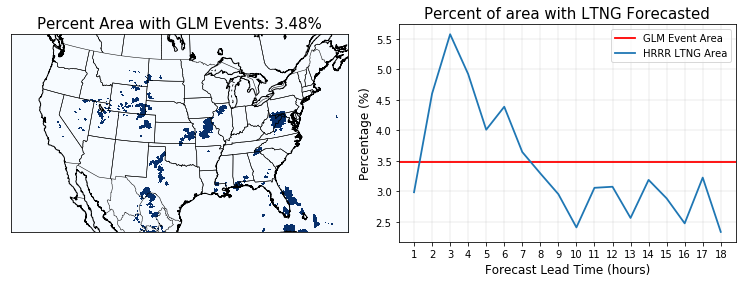

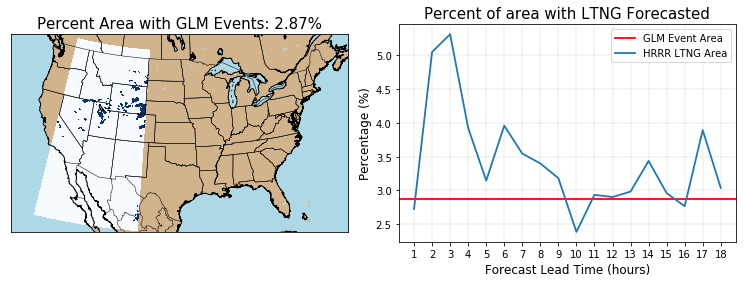

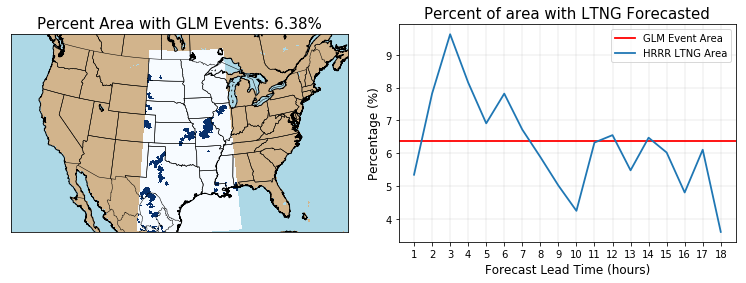

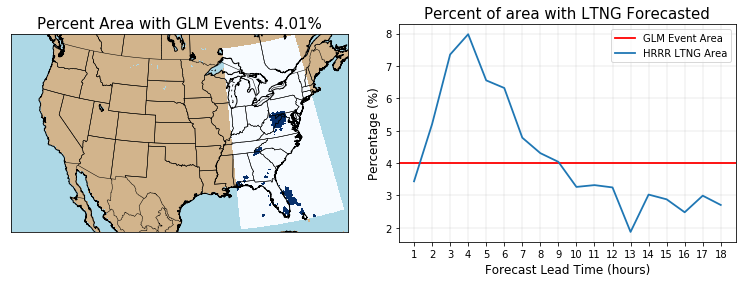

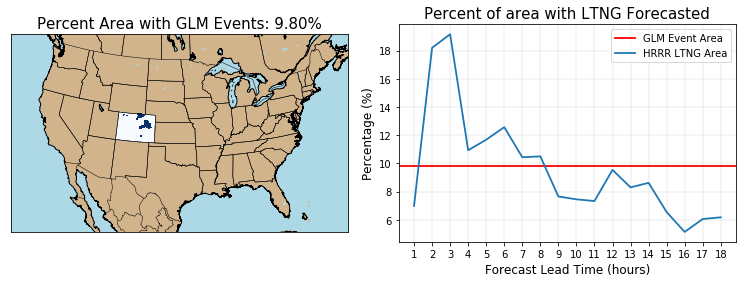

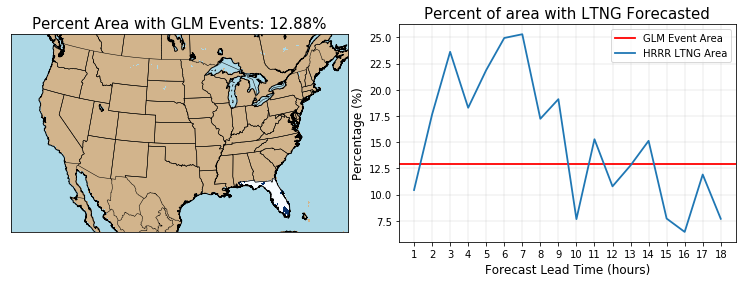

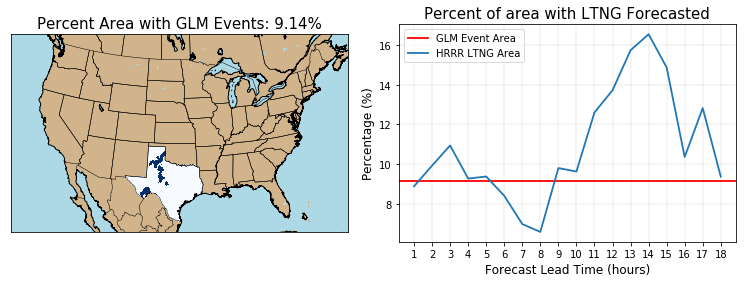

In [38]:
for DOMAIN in domains:
    total_DOMAIN_grid_points = np.sum(np.invert(domains[DOMAIN]['mask']))

    masked_array = np.ma.array(table['Observed Binary'], mask=domains[DOMAIN]['mask'])

    points_with_GLM= np.sum(masked_array)
    points_without_GLM = np.sum(np.invert(masked_array))
    
    percentage_with_GLM = points_with_GLM/total_DOMAIN_grid_points
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    plt.sca(ax1)
    plt.title('Percent Area with GLM Events: %.2f%%' % (percentage_with_GLM*100))
    m.pcolormesh(Hlon, Hlat, masked_array, latlon=True, cmap='Blues')
    m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines()
    
    plt.sca(ax2)
    LTNG_area = []
    for F in table['Forecast Binary']:
        masked_array = np.ma.array(F, mask=domains[DOMAIN]['mask'])
        points_with_LTNG= np.sum(masked_array)
        points_without_LTNG = np.sum(np.invert(masked_array))
        percentage_with_LTNG = points_with_LTNG/total_DOMAIN_grid_points
        LTNG_area.append(percentage_with_LTNG)
    
    plt.axhline(percentage_with_GLM*100, c='r', label='GLM Event Area')
    plt.plot(range(1,19), np.array(LTNG_area)*100, label='HRRR LTNG Area')
    plt.grid()
    #plt.ylim([0,15])
    plt.xticks(range(1,19))
    plt.ylabel('Percentage (%)')
    plt.xlabel('Forecast Lead Time (hours)')
    plt.title('Percent of area with LTNG Forecasted')
    plt.legend()

In [43]:
table = get_GLM_HRRR_contingency_stats(datetime(2018,7,27,0))

(1/7) Get GLM Events. 2018-07-27 00:00:00
**************************************************************
!!!WARNING!!! Missing GLM directory /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180726/23/
**************************************************************
************************************************************
!! WARNING !! There are no GLM files for the period requested!
************************************************************
************************************************************
!! WARNING !! There are no GLM files!
************************************************************

Got 0 of 180 expected files.
